In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

data = pd.read_csv('data/salary.csv').dropna()

threshold = 100000
data['HighIncome'] = (data['Salary'] > threshold).astype(int)

X = data[['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience']]
y = data['HighIncome']

categorical_features = ['Gender', 'Education Level', 'Job Title']
numeric_features = ['Age', 'Years of Experience']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.tree import DecisionTreeClassifier


def embedded_method(x_train, y_train, feature_names):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(x_train, y_train)

    feature_importances = model.feature_importances_

    sorted_features = np.argsort(feature_importances)[::-1]

    top_features = np.array(feature_names)[sorted_features[:30]]
    return top_features


In [5]:
from sklearn.feature_selection import SelectFromModel


def embedded_method(X, y, feature_names):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    selector = SelectFromModel(model, prefit=True)
    selected_features = selector.get_support()

    if len(selected_features) != len(feature_names):
        raise ValueError(
            f"Длина feature_names ({len(feature_names)}) не совпадает с количеством признаков ({len(selected_features)}).")

    return np.array(feature_names)[selected_features]

In [6]:
from scipy.stats import pearsonr


def filter_feature_selection(x_train, y_train, feature_names):
    if issparse(x_train):
        x_train = x_train.toarray()

    scores_filter = []

    for f in range(x_train.shape[1]):
        feature_column = x_train[:, f]
        if np.all(feature_column == feature_column[0]):
            scores_filter.append(0)
        else:
            corr, _ = pearsonr(feature_column, y_train)
            scores_filter.append(abs(corr))

    sorted_features_filter = np.argsort(scores_filter)[::-1]

    top_features = np.array(feature_names)[sorted_features_filter[:30]]
    return top_features


In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


def filter_method(X, y, feature_names):
    selector = SelectKBest(score_func=chi2, k=30)
    selector.fit(X, y)
    selected_features = selector.get_support()
    return np.array(feature_names)[selected_features]


In [8]:
from scipy.sparse import issparse


def wrapper_feature_selection(X, y, feature_names, n_features=30):
    if issparse(X):
        X = X.toarray()

    def calculate_feature_importance(X, y):
        feature_importance_temp = np.abs(np.corrcoef(X, y, rowvar=False)[-1, :-1])
        return feature_importance_temp

    def evaluate_model(X, y):
        return np.sum(np.dot(X, np.random.rand(X.shape[1])))

    selected_features = list(range(X.shape[1]))

    while len(selected_features) > n_features:
        feature_importance = calculate_feature_importance(X[:, selected_features], y)

        least_important_idx = np.argmin(feature_importance)
        del selected_features[least_important_idx]

        _ = evaluate_model(X[:, selected_features], y)

    top_features = [feature_names[i] for i in selected_features]
    return top_features


In [9]:
from sklearn.feature_selection import RFE


def wrapper_method(X, y, feature_names):
    model = LogisticRegression(max_iter=1000, random_state=42)
    rfe = RFE(model, n_features_to_select=30)
    rfe.fit(X, y)
    selected_features = rfe.get_support()
    return np.array(feature_names)[selected_features]

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
import joblib

data = pd.read_csv('data/salary.csv').dropna()

text_data = data['Job Title']

vectorizer = CountVectorizer(max_features=500)
X_text = vectorizer.fit_transform(text_data)

feature_names_text = vectorizer.get_feature_names_out()

numeric_features = data[['Age', 'Years of Experience']].values
categorical_features = pd.get_dummies(data[['Gender', 'Education Level']], drop_first=True).values

X_combined = hstack([numeric_features, categorical_features, X_text])

feature_names = (
    list(data[['Age', 'Years of Experience']].columns) +
    list(pd.get_dummies(data[['Gender', 'Education Level']], drop_first=True).columns) +
    list(feature_names_text)
)

y = (data['Salary'] > 100000).astype(int)

joblib.dump((X_combined, y, feature_names), 'vectorized_data.pkl')


['vectorized_data.pkl']

In [11]:
import joblib
from models.embedded_method_bible import embedded_method as embedded_method_bible
from models.filter_method_bible import filter_method as filter_method_bible
from models.wrapper_method_bible import wrapper_method as wrapper_method_bible

from models.embedded_method import embedded_method as embedded_method_own
from models.filter_method import filter_feature_selection as filter_method_own
from models.wrapper_method import wrapper_feature_selection as wrapper_method_own

X_combined, y, feature_names = joblib.load('data/vectorized_data.pkl')

embedded_features_bible = embedded_method_bible(X_combined, y, feature_names)
wrapper_features_bible = wrapper_method_bible(X_combined, y, feature_names)
filter_features_bible = filter_method_bible(X_combined, y, feature_names)

embedded_features_own = embedded_method_own(X_combined, y, feature_names)
wrapper_features_own = wrapper_method_own(X_combined, y, feature_names)
filter_features_own = filter_method_own(X_combined, y, feature_names)

print("Топ-30 признаков (встроенный метод - библиотечная реализация):", embedded_features_bible)
print("Топ-30 признаков (обёртка - библиотечная реализация):", wrapper_features_bible)
print("Топ-30 признаков (фильтрующий метод - библиотечная реализация):", filter_features_bible)

print("\nТоп-30 признаков (встроенный метод - ваша реализация):", embedded_features_own)
print("Топ-30 признаков (обёртка - ваша реализация):", wrapper_features_own)
print("Топ-30 признаков (фильтрующий метод - ваша реализация):", filter_features_own)

embedded_set_bible = set(embedded_features_bible)
wrapper_set_bible = set(wrapper_features_bible)
filter_set_bible = set(filter_features_bible)

embedded_set_own = set(embedded_features_own)
wrapper_set_own = set(wrapper_features_own)
filter_set_own = set(filter_features_own)

print("\nОбщие признаки между методами (библиотечные реализации):")
print("Встроенный и обёртка:", embedded_set_bible & wrapper_set_bible)
print("Встроенный и фильтрующий:", embedded_set_bible & filter_set_bible)
print("Обёртка и фильтрующий:", wrapper_set_bible & filter_set_bible)

print("\nОбщие признаки между методами (ваши реализации):")
print("Встроенный и обёртка:", embedded_set_own & wrapper_set_own)
print("Встроенный и фильтрующий:", embedded_set_own & filter_set_own)
print("Обёртка и фильтрующий:", wrapper_set_own & filter_set_own)

print("\nОбщие признаки между библиотечными и вашими методами:")
print("Встроенный метод:", embedded_set_bible & embedded_set_own)
print("Обёртка:", wrapper_set_bible & wrapper_set_own)
print("Фильтрующий метод:", filter_set_bible & filter_set_own)


Топ-30 признаков (встроенный метод - библиотечная реализация): ['Age' 'Years of Experience' 'Gender_Male' "Education Level_Master's"
 'Education Level_PhD' 'analyst' 'coordinator' 'director' 'junior'
 'manager' 'of' 'senior']
Топ-30 признаков (обёртка - библиотечная реализация): ['Age' 'Gender_Male' "Education Level_Master's" 'Education Level_PhD'
 'accountant' 'analyst' 'business' 'consultant' 'coordinator' 'data'
 'developer' 'director' 'engineer' 'executive' 'generalist' 'hr' 'manager'
 'marketing' 'office' 'operations' 'principal' 'product' 'project'
 'representative' 'sales' 'scientist' 'senior' 'software' 'specialist'
 'training']
Топ-30 признаков (фильтрующий метод - библиотечная реализация): ['Age' 'Years of Experience' "Education Level_Master's"
 'Education Level_PhD' 'accountant' 'advisor' 'analyst' 'associate'
 'consultant' 'coordinator' 'data' 'director' 'engineer' 'finance'
 'financial' 'generalist' 'human' 'junior' 'media' 'of' 'principal'
 'recruiter' 'representative' 'r

In [16]:
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score

X_combined, y, feature_names = joblib.load('data/vectorized_data.pkl')

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }


classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

print("Качество без отбора признаков:")
results_no_selection = {}
for name, clf in classifiers.items():
    results_no_selection[name] = evaluate_model(clf, X_train, X_test, y_train, y_test)
    print(f"{name}: {results_no_selection[name]}")

from models.filter_method import filter_feature_selection
selected_features = filter_feature_selection(X_train, y_train, feature_names)

selected_indices = [list(feature_names).index(f) for f in selected_features]
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

print("\nКачество после отбора признаков:")
results_with_selection = {}
for name, clf in classifiers.items():
    results_with_selection[name] = evaluate_model(clf, X_train_selected, X_test_selected, y_train, y_test)
    print(f"{name}: {results_with_selection[name]}")

print("\nСравнение результатов:")
for name in classifiers.keys():
    print(f"{name}:")
    print(f"  Без отбора: {results_no_selection[name]}")
    print(f"  С отбором: {results_with_selection[name]}")


Качество без отбора признаков:
Logistic Regression: {'accuracy': 0.9066666666666666, 'recall': 0.8823529411764706, 'f1_score': 0.8955223880597015}
Random Forest: {'accuracy': 0.9066666666666666, 'recall': 0.9411764705882353, 'f1_score': 0.9014084507042254}
Gradient Boosting: {'accuracy': 0.9066666666666666, 'recall': 0.9117647058823529, 'f1_score': 0.8985507246376812}

Качество после отбора признаков:
Logistic Regression: {'accuracy': 0.8666666666666667, 'recall': 0.8529411764705882, 'f1_score': 0.8529411764705882}
Random Forest: {'accuracy': 0.9066666666666666, 'recall': 0.9117647058823529, 'f1_score': 0.8985507246376812}
Gradient Boosting: {'accuracy': 0.9066666666666666, 'recall': 0.9117647058823529, 'f1_score': 0.8985507246376812}

Сравнение результатов:
Logistic Regression:
  Без отбора: {'accuracy': 0.9066666666666666, 'recall': 0.8823529411764706, 'f1_score': 0.8955223880597015}
  С отбором: {'accuracy': 0.8666666666666667, 'recall': 0.8529411764705882, 'f1_score': 0.85294117647

In [14]:
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

X_combined, y, feature_names = joblib.load('data/vectorized_data.pkl')

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }


classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

print("Качество без отбора признаков:")
results_no_selection = {}
for name, clf in classifiers.items():
    results_no_selection[name] = evaluate_model(clf, X_train, X_test, y_train, y_test)
    print(f"{name}: {results_no_selection[name]}")

from models.filter_method import filter_feature_selection
selected_features = filter_feature_selection(X_train, y_train, feature_names)

selected_indices = [list(feature_names).index(f) for f in selected_features]
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

print("\nКачество после отбора признаков:")
results_with_selection = {}
for name, clf in classifiers.items():
    results_with_selection[name] = evaluate_model(clf, X_train_selected, X_test_selected, y_train, y_test)
    print(f"{name}: {results_with_selection[name]}")

print("\nКластеризация до отбора признаков:")
kmeans_no_selection = KMeans(n_clusters=2, random_state=42)
labels_no_selection = kmeans_no_selection.fit_predict(X_train)
ari_no_selection = adjusted_rand_score(y_train, labels_no_selection)
silhouette_no_selection = silhouette_score(X_train, labels_no_selection)
print(f"Adjusted Rand Index: {ari_no_selection}")
print(f"Silhouette Score: {silhouette_no_selection}")

print("\nКластеризация после отбора признаков:")
kmeans_with_selection = KMeans(n_clusters=2, random_state=42)
labels_with_selection = kmeans_with_selection.fit_predict(X_train_selected)
ari_with_selection = adjusted_rand_score(y_train, labels_with_selection)
silhouette_with_selection = silhouette_score(X_train_selected, labels_with_selection)
print(f"Adjusted Rand Index: {ari_with_selection}")
print(f"Silhouette Score: {silhouette_with_selection}")

print("\nСравнение кластеризации:")
print("До отбора признаков:")
print(f"  Adjusted Rand Index: {ari_no_selection}")
print(f"  Silhouette Score: {silhouette_no_selection}")
print("После отбора признаков:")
print(f"  Adjusted Rand Index: {ari_with_selection}")
print(f"  Silhouette Score: {silhouette_with_selection}")


Качество без отбора признаков:
Logistic Regression: {'accuracy': 0.9066666666666666, 'recall': 0.8823529411764706, 'f1_score': 0.8955223880597015}
Random Forest: {'accuracy': 0.9066666666666666, 'recall': 0.9411764705882353, 'f1_score': 0.9014084507042254}
Gradient Boosting: {'accuracy': 0.9066666666666666, 'recall': 0.9117647058823529, 'f1_score': 0.8985507246376812}

Качество после отбора признаков:
Logistic Regression: {'accuracy': 0.8666666666666667, 'recall': 0.8529411764705882, 'f1_score': 0.8529411764705882}
Random Forest: {'accuracy': 0.9066666666666666, 'recall': 0.9117647058823529, 'f1_score': 0.8985507246376812}
Gradient Boosting: {'accuracy': 0.9066666666666666, 'recall': 0.9117647058823529, 'f1_score': 0.8985507246376812}

Кластеризация до отбора признаков:
Adjusted Rand Index: 0.6151143397978602
Silhouette Score: 0.5995581081704973

Кластеризация после отбора признаков:
Adjusted Rand Index: 0.6151143397978602
Silhouette Score: 0.6140310671782329

Сравнение кластеризации:


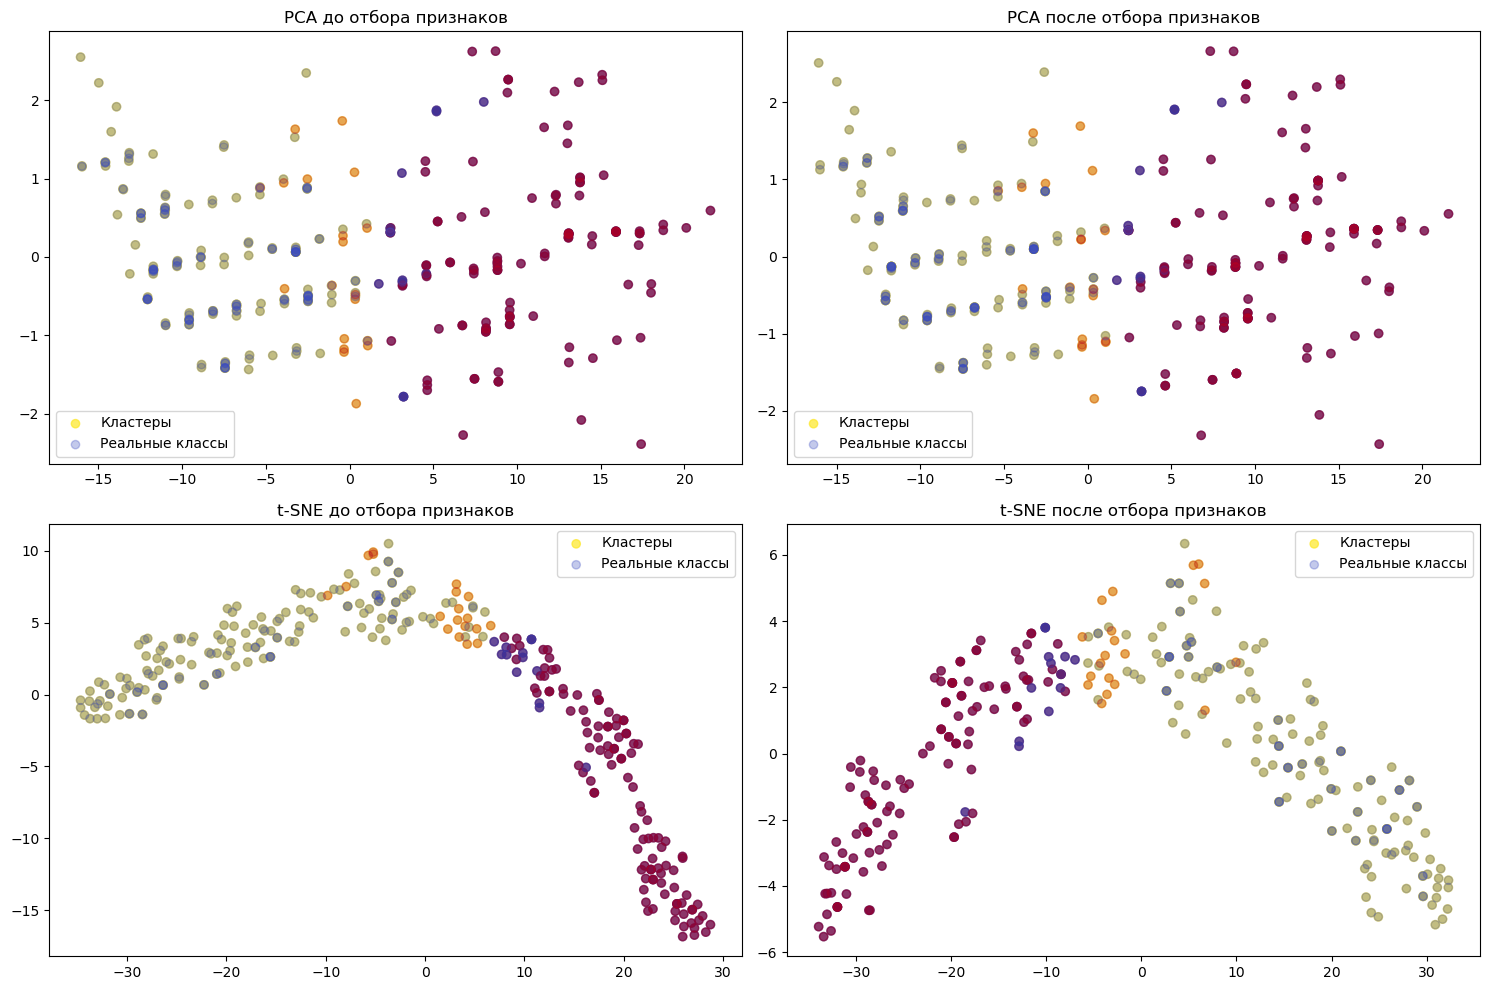

In [15]:
import joblib
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from models.filter_method import filter_feature_selection

# Загрузка данных
X_combined, y, feature_names = joblib.load('data/vectorized_data.pkl')

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Выполнение отбора признаков (фильтрующий метод)
selected_features = filter_feature_selection(X_train, y_train, feature_names)
selected_indices = [list(feature_names).index(f) for f in selected_features]
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

# Кластеризация до и после отбора признаков
kmeans_before = KMeans(n_clusters=2, random_state=42)
kmeans_after = KMeans(n_clusters=2, random_state=42)

clusters_before = kmeans_before.fit_predict(X_train.toarray())
clusters_after = kmeans_after.fit_predict(X_train_selected)

# PCA до и после отбора признаков
pca_before = PCA(n_components=2, random_state=42)
pca_after = PCA(n_components=2, random_state=42)

X_pca_before = pca_before.fit_transform(X_train.toarray())
X_pca_after = pca_after.fit_transform(X_train_selected)

# t-SNE до и после отбора признаков
tsne_before = TSNE(n_components=2, random_state=42, init='random')
tsne_after = TSNE(n_components=2, random_state=42, init='random')

X_tsne_before = tsne_before.fit_transform(X_train.toarray())
X_tsne_after = tsne_after.fit_transform(X_train_selected)

# Визуализация данных
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# PCA до отбора признаков
axes[0, 0].scatter(X_pca_before[:, 0], X_pca_before[:, 1], c=clusters_before, cmap='viridis', alpha=0.7, label='Кластеры')
axes[0, 0].scatter(X_pca_before[:, 0], X_pca_before[:, 1], c=y_train, cmap='coolwarm', alpha=0.3, label='Реальные классы')
axes[0, 0].set_title('PCA до отбора признаков')
axes[0, 0].legend()

# PCA после отбора признаков
axes[0, 1].scatter(X_pca_after[:, 0], X_pca_after[:, 1], c=clusters_after, cmap='viridis', alpha=0.7, label='Кластеры')
axes[0, 1].scatter(X_pca_after[:, 0], X_pca_after[:, 1], c=y_train, cmap='coolwarm', alpha=0.3, label='Реальные классы')
axes[0, 1].set_title('PCA после отбора признаков')
axes[0, 1].legend()

# t-SNE до отбора признаков
axes[1, 0].scatter(X_tsne_before[:, 0], X_tsne_before[:, 1], c=clusters_before, cmap='viridis', alpha=0.7, label='Кластеры')
axes[1, 0].scatter(X_tsne_before[:, 0], X_tsne_before[:, 1], c=y_train, cmap='coolwarm', alpha=0.3, label='Реальные классы')
axes[1, 0].set_title('t-SNE до отбора признаков')
axes[1, 0].legend()

# t-SNE после отбора признаков
axes[1, 1].scatter(X_tsne_after[:, 0], X_tsne_after[:, 1], c=clusters_after, cmap='viridis', alpha=0.7, label='Кластеры')
axes[1, 1].scatter(X_tsne_after[:, 0], X_tsne_after[:, 1], c=y_train, cmap='coolwarm', alpha=0.3, label='Реальные классы')
axes[1, 1].set_title('t-SNE после отбора признаков')
axes[1, 1].legend()

plt.tight_layout()
plt.show()
